In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot

In [32]:
# Variabili globali

path = 'acquisizione 15_05_2023/'

In [33]:
allacqui = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


In [34]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,15)):
    if(b < 4 or b > 11):
        allacqui.append(pd.read_csv(path+a,sep=','))
    else:
        allacqui.append(pd.read_csv(path+a,sep='\t'))

In [35]:
# Check delle dimensioni

print(type(allacqui[4][:10].mean()))

for a in range(len(allacqui)):
    print(allacqui[a].shape)

<class 'pandas.core.series.Series'>
(120, 2)
(120, 2)
(121, 2)
(121, 2)
(14396, 2)
(14614, 2)
(14149, 2)
(14390, 2)
(119, 2)
(119, 2)
(120, 2)
(120, 2)


In [36]:
media_mobile_ni = pd.DataFrame(columns=[])

for b in range(0,allacqui[4].shape[0],1):
    media_mobile_ni = pd.concat([media_mobile_ni,pd.DataFrame(allacqui[4][b:10+b].mean()).transpose()],ignore_index=True)

In [37]:
print(type(allacqui[0]))
print(allacqui[0].head(10))

<class 'pandas.core.frame.DataFrame'>
               time   volts
0  1684165689446600  15.804
1  1684165689960659  15.804
2  1684165690458684  15.804
3  1684165690959026  15.804
4  1684165691457592  15.801
5  1684165691970705  15.802
6  1684165692455274  15.804
7  1684165692970649  15.802
8  1684165693453095  15.804
9  1684165693970378  15.800


In [38]:
print(allacqui[0]['volts'])

0      15.804
1      15.804
2      15.804
3      15.804
4      15.801
        ...  
115    14.482
116    14.476
117    14.485
118    14.476
119    14.479
Name: volts, Length: 120, dtype: float64


In [39]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[3]['volts']
grid_points = allacqui[3]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=3)
)

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


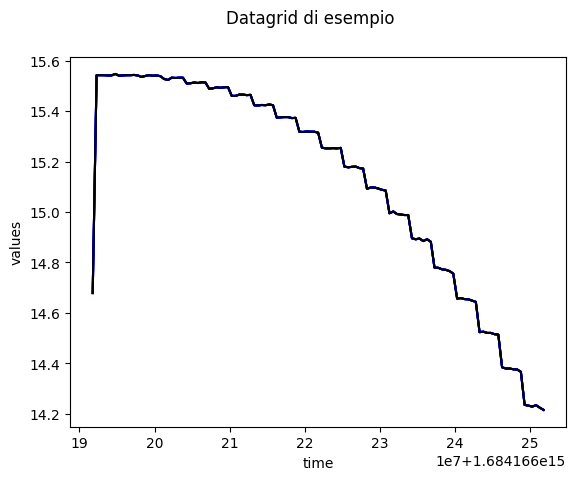

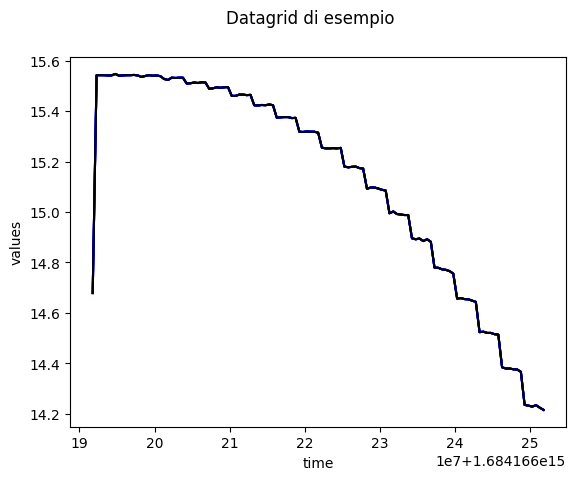

In [40]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [41]:
# Andiamo a definire un datagrid per ogni dataframe

all_data_grid = []

for a,b in zip(allacqui,path_acquisizioni):
    
    data_matrix = a[a.columns.values[1]]
    grid_points = a[a.columns.values[0]]

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name=b,
    argument_names=(a.columns.values[0],),
    coordinate_names=(a.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

In [42]:
print(len(all_data_grid))

12


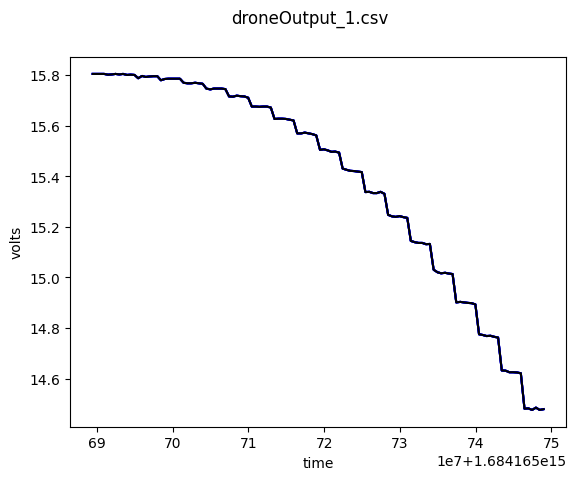

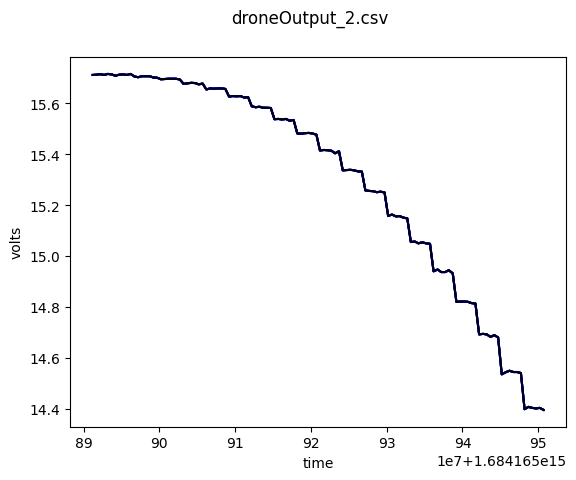

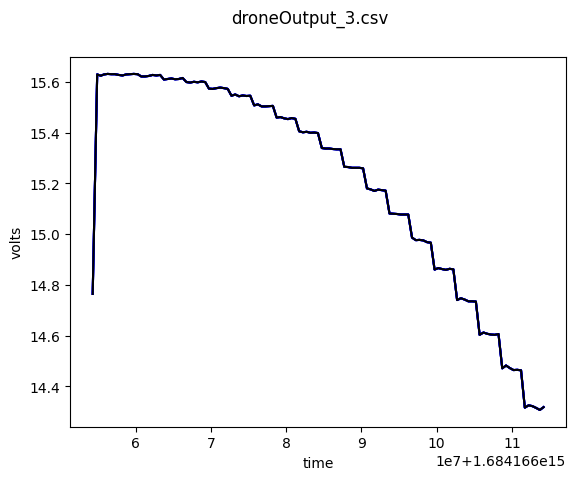

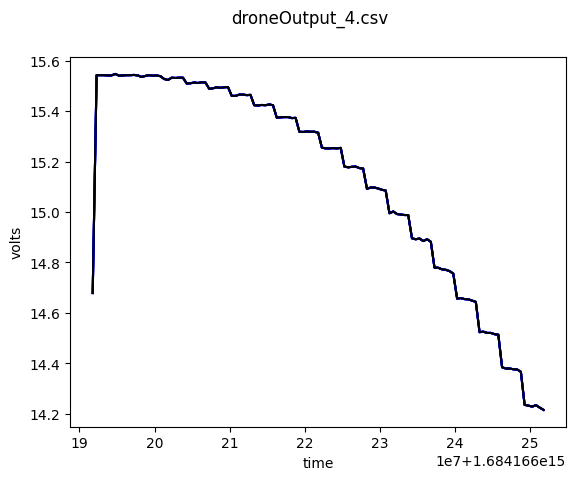

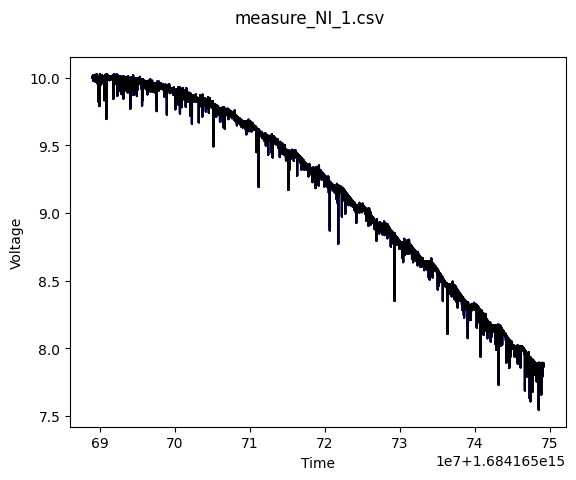

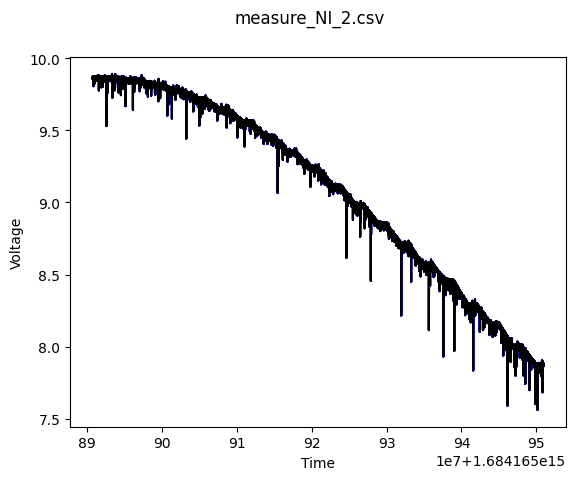

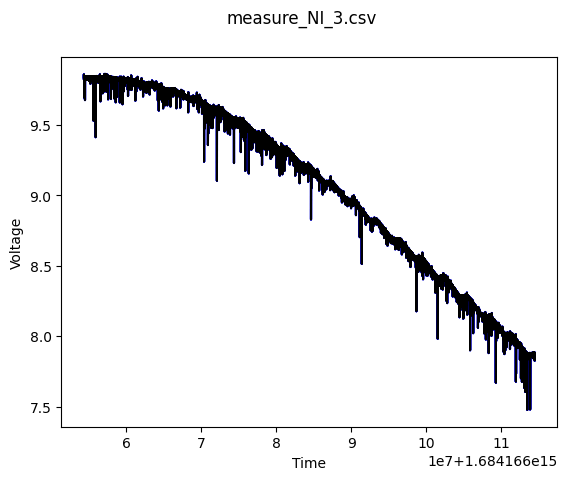

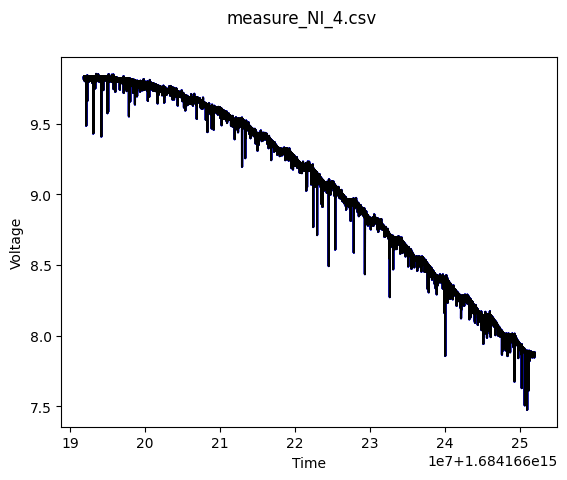

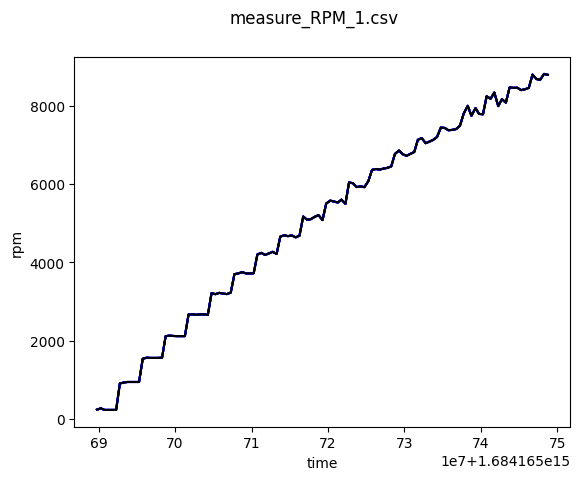

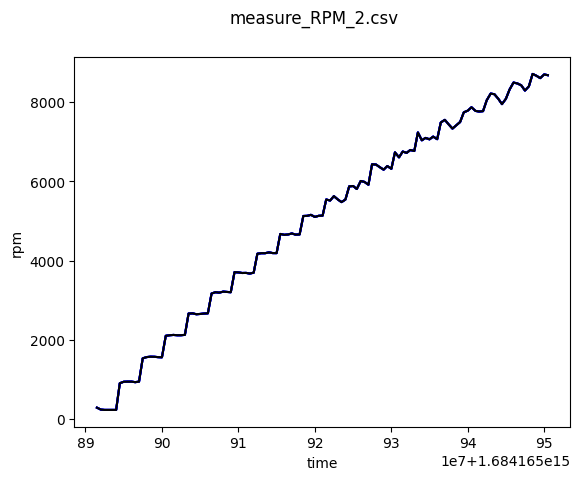

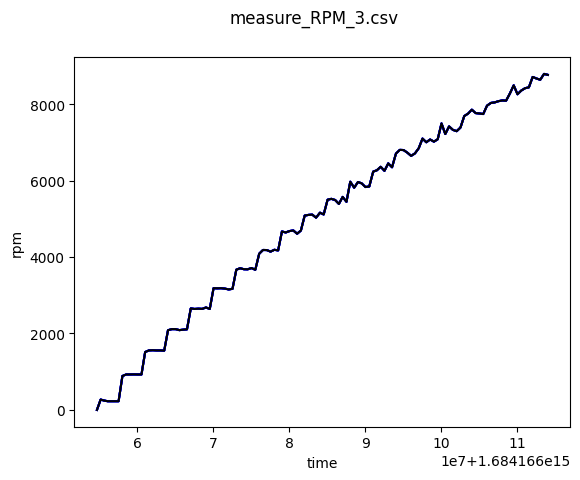

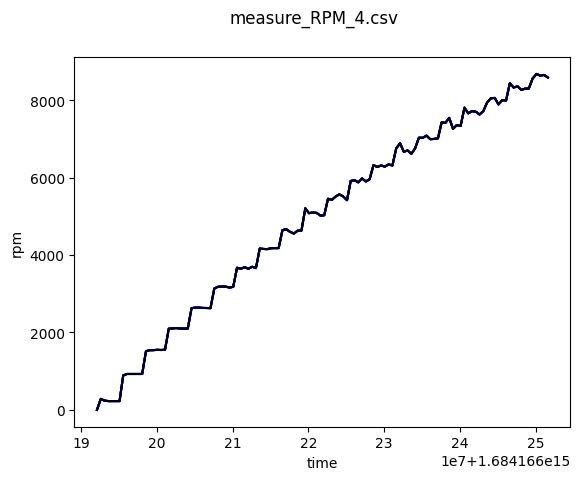

In [43]:
for a in all_data_grid:
    Boxplot(a).plot()